# Loading the data and required libraries

In [76]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [2]:
DIR = "E:/Coding/Summer 2023/data/"

In [3]:
notes_df = pd.read_csv(DIR + "NOTEEVENTS.csv", low_memory=False, memory_map=True)
admissions_df = pd.read_csv(DIR + "ADMISSIONS.csv", low_memory=False)

# Data Exploration
## Admissions

In [4]:
admissions_df.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [5]:
admissions_df.shape

(58976, 19)

Types of admissions

In [6]:
admissions_df['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'NEWBORN', 'URGENT'], dtype=object)

Check for missing values on the admission times

In [7]:
sum(admissions_df['ADMITTIME'].isnull())


0

Conversion of times to datetime type

In [8]:
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[ns]')
admissions_df['DISCHTIME'] = admissions_df['DISCHTIME'].astype('datetime64[ns]')
admissions_df['DEATHTIME'] = admissions_df['DEATHTIME'].astype('datetime64[ns]')

Sort by subject and admission type and reset the data frame index.

In [9]:
admissions_df = admissions_df.sort_values(['SUBJECT_ID', 'ADMITTIME'])
admissions_df = admissions_df.reset_index(drop = True)

In [10]:
admissions_df['NEXT_ADMITTIME'] = admissions_df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admissions_df['NEXT_ADMISSION_TYPE'] = admissions_df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [12]:
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMITTIME'] = pd.NaT
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMISSION_TYPE'] = np.NaN

Fill NA's with the next valid value. Previously sorted.

In [13]:
admissions_df[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions_df.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

Obtain days to readmission: from discharge to next readmission

In [14]:
admissions_df['DAYS_TO_READMISSION'] = (admissions_df['NEXT_ADMITTIME'] - admissions_df['DISCHTIME']).dt.days

Number of readmissions

In [15]:
sum(admissions_df['DAYS_TO_READMISSION'].notnull())

11399

Distribution of days to readmission

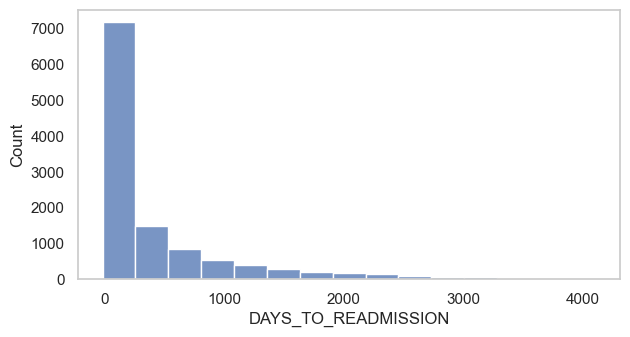

In [87]:
sns.set(rc={'figure.figsize':(7,3.5), 'axes.grid':True})
sns.set_style("whitegrid", {'axes.grid' : False})
fig = sns.histplot(admissions_df['DAYS_TO_READMISSION'], kde=False, bins=15)
fig = fig.get_figure()

In [20]:
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.5))
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.75))
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.25))
print(admissions_df['DAYS_TO_READMISSION'].mean())
admissions_df['DAYS_TO_READMISSION'].max()

120.0
507.0
23.0
408.8103342398456


4107.0

## Notes

In [21]:
notes_df.head()

ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Discharge summary      Report   NaN      NaN   

                                                TEXT  
0  Admission Date:  [**2151-7-16**]       Dischar...  
1  Admission Date:  [**2118-6-2**]       Discharg...  
2  Admission Date:  [**2119-5-4**]              D...  
3  Admission Date:  [**2124-7-21**]              ...  
4  Admission Date:  [**2162-3-3**]              D...

In [22]:
notes_df.shape

(2083180, 11)

In [23]:
notes_df['CATEGORY'].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [24]:
discharge_notes = notes_df[notes_df['CATEGORY'] == "Discharge summary"]
discharge_notes.shape

(59652, 11)

There are 6926 admissions with more than one discharge note (HADM_ID - ID of Admissions).

In [25]:
discharge_notes.duplicated(['HADM_ID']).sum()

6926

Take the last row per admission

In [26]:
discharge_notes_ordered = discharge_notes.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1).reset_index()

In [27]:
discharge_notes_ordered.duplicated(['HADM_ID']).sum()

0

In [28]:
discharge_notes_ordered.shape

(52726, 11)

## Merge Notes and Admissions

In [29]:
admissions_notes = pd.merge(
    admissions_df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_TO_READMISSION','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
    discharge_notes_ordered[['SUBJECT_ID', 'HADM_ID', 'TEXT']], 
    on = ['SUBJECT_ID', 'HADM_ID'], how='left'
)

In [30]:
admissions_notes

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0               2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
1               3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
2               4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
3               5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
4               6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
...           ...      ...                 ...                 ...   
58971       99985   176670 2181-01-27 02:47:00 2181-02-12 17:05:00   
58972       99991   151118 2184-12-24 08:30:00 2185-01-05 12:15:00   
58973       99992   197084 2144-07-25 18:03:00 2144-07-28 17:56:00   
58974       99995   137810 2147-02-08 08:00:00 2147-02-11 13:15:00   
58975       99999   113369 2117-12-30 07:15:00 2118-01-04 16:30:00   

       DAYS_TO_READMISSION NEXT_ADMITTIME ADMISSION_TYPE DEATHTIME  \
0                      NaN            NaT        NEWBORN       NaT   
1                      NaN            NaT      EMERGENCY       NaT   
2                      NaN            NaT      EMERGENCY       NaT   
3                      NaN            NaT        NEWBORN       NaT   
4                      NaN            NaT       ELECTIVE       NaT   
...                    ...            ...            ...       ...   
58971                  NaN            NaT      EMERGENCY       NaT   
58972                  NaN            NaT       ELECTIVE       NaT   
58973                  NaN            NaT      EMERGENCY       NaT   
58974                  NaN            NaT       ELECTIVE       NaT   
58975                  NaN            NaT       ELECTIVE       NaT   

                                                    TEXT  
0                                                    NaN  
1      Admission Date:  [**2101-10-20**]     Discharg...  
2      Admission Date:  [**2191-3-16**]     Discharge...  
3                                                    NaN  
4      Admission Date: [**2175-5-30**]        Dischar...  
...                                                  ...  
58971  Admission Date:  [**2181-1-27**]              ...  
58972  Admission Date:  [**2184-12-24**]             ...  
58973  Admission Date:  [**2144-7-25**]              ...  
58974  Admission Date:  [**2147-2-8**]              D...  
58975  Admission Date:  [**2117-12-30**]             ...  

[58976 rows x 9 columns]

10% of admissions without discharge notes.

In [31]:
sum(admissions_notes['TEXT'].isnull()) / len(admissions_notes)

0.1059753119913185

53% of NEWBORN are missing

In [41]:
admissions_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/admissions_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

Remove NEWBORN admissions and create the target variable

In [42]:
adm_notes = admissions_notes[admissions_notes['ADMISSION_TYPE'] != 'NEWBORN'].copy()
adm_notes['READM_WITHIN_30'] = (adm_notes['DAYS_TO_READMISSION'] < 30).astype('int')

In [43]:
sum(adm_notes['READM_WITHIN_30'])

3004

In [44]:
adm_notes.shape

(51113, 10)

Exlude patients that died during the admission

In [45]:
rows_not_death = adm_notes['DEATHTIME'].isnull()
df_adm_notes_not_death = adm_notes.loc[rows_not_death].copy()
df_adm_notes_not_death = df_adm_notes_not_death.sample(n = len(df_adm_notes_not_death))
df_adm_notes_not_death = df_adm_notes_not_death.reset_index(drop = True)

In [46]:
sum(df_adm_notes_not_death['READM_WITHIN_30'])

2963

In [47]:
len(df_adm_notes_not_death['READM_WITHIN_30'])

45321

# Data Creation

Exlude patients that died during the admission

In [60]:
adm_notes = adm_notes.loc[adm_notes['DEATHTIME'].isnull()]
adm_notes = adm_notes.sample(n = len(adm_notes))
adm_notes = adm_notes.reset_index(drop = True)

In [61]:
adm_notes

SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0            6090   175043 2170-05-03 07:15:00 2170-05-06 13:40:00   
1           27901   189210 2101-06-21 07:15:00 2101-07-13 15:00:00   
2           69531   102759 2156-08-18 23:41:00 2156-08-26 16:45:00   
3            8620   148993 2190-02-05 17:13:00 2190-02-09 17:53:00   
4           24226   118785 2113-04-04 07:30:00 2113-04-14 11:20:00   
...           ...      ...                 ...                 ...   
45316       17882   157780 2146-05-01 16:33:00 2146-05-09 16:20:00   
45317        2184   171742 2154-04-21 19:25:00 2154-04-25 11:49:00   
45318       28240   151747 2195-06-21 07:27:00 2195-06-26 14:33:00   
45319       25201   124241 2149-06-02 08:00:00 2149-06-11 13:00:00   
45320       20855   108604 2161-07-31 17:00:00 2161-08-20 16:00:00   

       DAYS_TO_READMISSION      NEXT_ADMITTIME ADMISSION_TYPE DEATHTIME  \
0                      NaN                 NaT       ELECTIVE       NaT   
1                     50.0 2101-09-01 20:44:00       ELECTIVE       NaT   
2                      8.0 2156-09-03 21:11:00      EMERGENCY       NaT   
3                      NaN                 NaT       ELECTIVE       NaT   
4                      NaN                 NaT       ELECTIVE       NaT   
...                    ...                 ...            ...       ...   
45316                412.0 2147-06-25 17:42:00      EMERGENCY       NaT   
45317                  NaN                 NaT      EMERGENCY       NaT   
45318                154.0 2195-11-28 00:15:00      EMERGENCY       NaT   
45319                  NaN                 NaT       ELECTIVE       NaT   
45320                  NaN                 NaT      EMERGENCY       NaT   

                                                    TEXT  READM_WITHIN_30  
0      Admission Date:  [**2170-5-3**]              D...                0  
1      Admission Date:  [**2101-6-21**]              ...                0  
2      Admission Date:  [**2156-8-18**]              ...                1  
3      Admission Date:  [**2190-2-5**]     Discharge ...                0  
4      Name:  [**Known lastname 10030**],[**Known fir...                0  
...                                                  ...              ...  
45316  Admission Date:  [**2146-5-1**]              D...                0  
45317  Admission Date:  [**2154-4-21**]     Discharge...                0  
45318  Admission Date:  [**2195-6-21**]              ...                0  
45319  Admission Date:  [**2149-6-2**]              D...                0  
45320  Admission Date:  [**2161-7-31**]       Dischar...                0  

[45321 rows x 10 columns]

In [62]:
adm_notes.to_csv(DIR + 'readmission.csv', index=False)

# Data Cleaning

## Natural Language

In [77]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [79]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [82]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [83]:
porter = PorterStemmer()

In [84]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [85]:
print(sum(adm_notes['READM_WITHIN_30'] == 1) )
print(len(adm_notes['READM_WITHIN_30']))

2963
45321
